In [1]:
import os
import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.vgg16 import preprocess_input, decode_predictions
from matplotlib.colors import LinearSegmentedColormap
from keras.initializers import glorot_uniform
import matplotlib.pyplot as plt
from skimage.segmentation import slic
%matplotlib inline
from skimage.io import imread
import numpy as np
import shap
from PIL import Image

In [2]:
import numpy as np
import os
import tensorflow as tf
import pandas as pd
from keras import models, optimizers, backend
from keras.layers import core, convolutional, pooling
from sklearn import model_selection
import cv2
import random

from tensorflow.keras.utils import Sequence
import matplotlib.image as mpimg

from PIL import Image
import skimage 
from skimage.transform import resize

from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from sklearn.preprocessing import LabelEncoder


from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
from lime import lime_image

from keras.applications import inception_v3 as inc_net
from keras.applications.imagenet_utils import decode_predictions
from skimage.segmentation import mark_boundaries





In [3]:
with tf.keras.utils.custom_object_scope({'GlorotUniform': glorot_uniform()}):
    model = keras.models.load_model('C:/Users/Ketan/Thesis/self-driving-car/challenges/udacity_classification_custom_model_v3.h5', compile=False)


In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 160, 213, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 80, 107, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 35, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 18, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 6, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 3, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 384)               0

In [5]:
# def transform_img_fn(path_list):
#     out = []
#     for img_path in path_list:
#         img = image.load_img((img_path), target_size=(480, 640))
#         x = image.img_to_array(img)
#         x = np.expand_dims(x, axis=0)
#         x = inc_net.preprocess_input(x)
#         out.append(x)
#     return np.vstack(out) /2 +0.5

In [6]:
# image_paths = []
# for _, _, files in os.walk(image_dataset):
#     for file in files:
#         image_paths.append(os.path.join(image_dataset, file))

# images = transform_img_fn([os.path.join(r'C:/Users/Ketan/Thesis/self-driving-car/challenges/challenge-2/1479425441232704425.jpg')])


In [7]:
def open_images(inference_folder: str) -> np.ndarray:
    """Loads images from a folder and prepare them for inferencing.

    Parameters
    ----------
    inference_folder : str
        Location of images for inferencing.

    Returns
    -------
    np.ndarray
        List of images as numpy arrays transformed to fit the efficient_net model input specs.
    """
    images = []
    for img in os.listdir(inference_folder):
        img_location = os.path.join(inference_folder, img)  # create full path to image

        with Image.open(img_location) as img:  # open image with pillow

            img = np.array(img)
            img = img[:, :, :3]
            img = np.expand_dims(img, axis=0)  # add 0 dimension to fit input shape of efficient_net
            img = inc_net.preprocess_input(img)

        images.append(img)
    images_array = np.vstack(images)/2+0.5# combine images efficiently to a numpy array
    return images_array

In [48]:
images = open_images("C:/Users/Ketan/Thesis/self-driving-car/challenges/test_dataset_480x640")


In [49]:
images.shape

(1, 480, 640, 3)

In [50]:
file = "C:/Users/Ketan/Thesis/self-driving-car/challenges/test_dataset_480x640/1479425533948818614.jpg"
img1 = image.load_img(file, target_size=(480, 640))
# img_orig = image.img_to_array(img1)

In [51]:
model.predict(images)

array([[9.9521637e-01, 4.7715832e-03, 1.1286191e-05, 3.1752870e-10,
        2.8878679e-07, 8.4180113e-10, 1.2958883e-09, 9.1267305e-09,
        1.0934272e-08, 4.7452465e-07]], dtype=float32)

In [52]:
model.predict(images).shape

(1, 10)

In [53]:
images_sample = images.reshape(480,640,3)

In [54]:
# segment the image so with don't have to explain every pixel
segments_slic = slic(images_sample, n_segments=50, compactness=30, sigma=3,slic_zero=True)

skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.


In [55]:
segments_slic

array([[ 0,  0,  0, ...,  7,  7,  7],
       [ 0,  0,  0, ...,  7,  7,  7],
       [ 0,  0,  0, ...,  7,  7,  7],
       ...,
       [46, 46, 46, ..., 41, 41, 41],
       [46, 46, 46, ..., 41, 41, 41],
       [46, 46, 46, ..., 41, 41, 41]], dtype=int64)

In [56]:
segments_slic.shape

(480, 640)

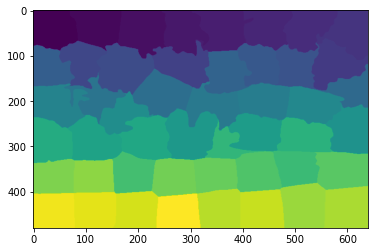

In [57]:
plt.imshow(segments_slic,aspect="auto")
plt.show()

In [58]:
# define a function that depends on a binary mask representing if an image region is hidden
def mask_image(zs, segmentation, image, background=None):
    if background is None:
        background = image.mean((0,1))
    out = np.zeros((zs.shape[0], image.shape[0], image.shape[1], image.shape[2]))
    for i in range(zs.shape[0]):
        out[i,:,:,:] = image
        for j in range(zs.shape[1]):
            if zs[i,j] == 0:
                out[i][segmentation == j,:] = background
    return out
def f(z):
    return model.predict(mask_image(z, segments_slic, images_sample, 255))
def ab(z):
    return model.predict(images_sample)

In [59]:
# abc = mask_image(z, segments_slic, images_sample, 255)

In [60]:
# use Kernel SHAP to explain the network's predictions
explainer = shap.KernelExplainer(f, np.zeros((1,50)))
shap_values = explainer.shap_values(np.ones((1,50)), nsamples=1000)#,max_evals=300)

  0%|          | 0/1 [00:00<?, ?it/s]

In [61]:
# get the top predictions from the model
preds = model.predict(np.expand_dims(images_sample.copy(), axis=0))
top_preds = np.argsort(-preds)


In [62]:
# y = 2 * images.shape[2] + 2048
# y

In [63]:
top_preds

array([[0, 1, 2, 9, 4, 8, 7, 6, 5, 3]], dtype=int64)

In [64]:
# make a color map
from matplotlib.colors import LinearSegmentedColormap
colors = []
for l in np.linspace(1,0,100):
    colors.append((245/255,39/255,87/255,l))
for l in np.linspace(0,1,100):
    colors.append((24/255,196/255,93/255,l))
cm = LinearSegmentedColormap.from_list("shap", colors)

In [65]:
feature_names = {'0' : '0', '1': '1', '2': '2','3': '3','4': '4','5': '5','6': '6','7': '7','8': '8','9': '9'} 

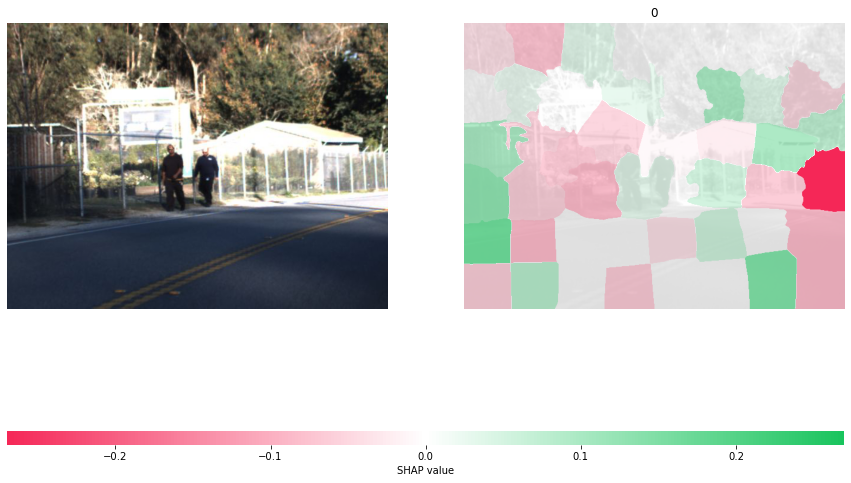

In [67]:
def fill_segmentation(values, segmentation):
    out = np.zeros(segmentation.shape)
    for i in range(len(values)):
        out[segmentation == i] = values[i]
    return out

# plot our explanations
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,15))
inds = top_preds[0]
axes[0].imshow(images_sample)
axes[0].axis('off')
max_val = np.max([np.max(np.abs(shap_values[i][:,:-1])) for i in range(len(shap_values))])
for i in range(1):
    m = fill_segmentation(shap_values[inds[i]][0], segments_slic)
    axes[i+1].set_title(feature_names[str(inds[i])][0])
    axes[i+1].imshow(img1.convert('LA'), alpha=0.15)
    im = axes[i+1].imshow(m, cmap=cm, vmin=-max_val, vmax=max_val)
    axes[i+1].axis('off')
cb = fig.colorbar(im, ax=axes.ravel().tolist(), label="SHAP value", orientation="horizontal", aspect=60)
cb.outline.set_visible(False)
plt.savefig('C:/Users/Ketan/Thesis/self-driving-car/challenges/explanations_resized/SHAP/1479425533948818614.jpg', dpi=300)
plt.show()


In [26]:
def F(x):
    tmp = x.copy()
#     preprocess_input(tmp)
    return model(tmp)

In [230]:
masker2 = shap.maskers.Image("inpaint_telea", images[0].shape)


In [231]:
explainer2 = shap.Explainer(F, masker2)#, output_names=feature_names)


In [232]:
shap_values2 = explainer2(images, max_evals=300, batch_size=50, outputs=shap.Explanation.argsort.flip[:3])


  0%|          | 0/148 [00:00<?, ?it/s]

Partition explainer: 2it [01:56, 116.85s/it]                                                                           


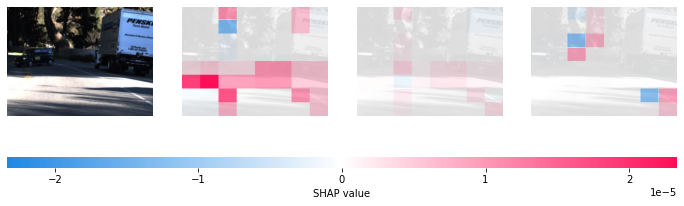

In [233]:

shap.image_plot(shap_values2, show=False)
plt.savefig('C:/Users/Ketan/Thesis/self-driving-car/challenges/explanations_resized/custom_classification_SHAP/1479425577406411560_e2.jpg', dpi=300)



In [ ]:
masker1 = shap.maskers.Image("blur(2,2)", images[0].shape)


In [181]:
explainer1 = shap.Explainer(F, masker1)#, output_names=feature_names)


In [182]:
shap_values1 = explainer1(images, max_evals=300, batch_size=50, outputs=shap.Explanation.argsort.flip[:3])


  0%|          | 0/148 [00:00<?, ?it/s]

Partition explainer: 2it [00:38, 38.49s/it]                                                                            


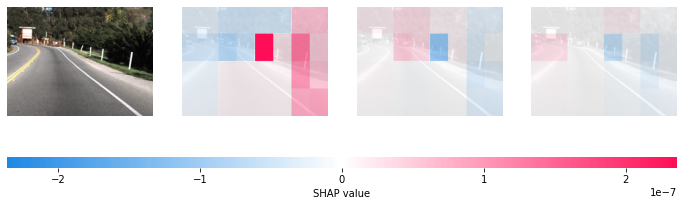

In [183]:

shap.image_plot(shap_values1, show=False)
plt.savefig('C:/Users/Ketan/Thesis/self-driving-car/challenges/explanations_resized/custom_classification_SHAP/1479425462286259544_e.jpg', dpi=300)



In [39]:
explainer2 = shap.DeepExplainer(model, images)


keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.


In [40]:
shap_values2 = explainer2.shap_values(images)


`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


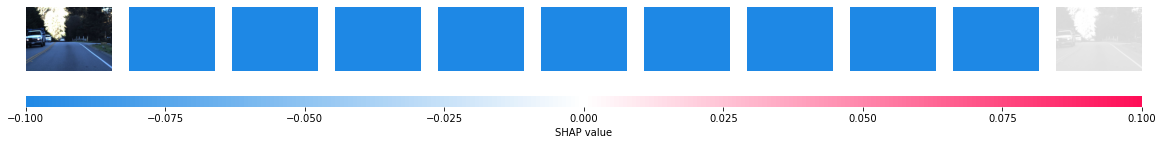

In [41]:
shap.image_plot(shap_values2, images)
